In [1]:
import numpy as np
from typing import List
from sklearn.metrics import r2_score as r2_sklean
from itertools import combinations

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Задача 1

Дана матрица объект-признак X
и значения целевой переменной y.

Подберите два признака (из четырёх) так, чтобы уровень линейной зависимости целевой переменной от значений этих признаков был максимальным. Другими словами, модель линейной регрессии на этих признаках должна давать наилучший результат. В качестве ответа запишите значение коэффициента детерминации для модели на этих признаках.

Ответ: 0.76342462

In [24]:
X = [[ 1.22401313,  2.30868478,  3.03636353,  2.69287214],
     [-0.18757272,  1.30337355,  5.12093014,  3.46363202],
     [-0.81094525,  1.82463398,  5.79686488,  1.86159445],
     [ 0.75129018,  2.67392052,  3.65529809,  1.66746094],
     [ 0.00972362,  1.97367255,  2.50594319,  1.69755173],
     [-0.62972637,  0.77750764,  2.84124027,  4.54410559],
     [ 2.29536229,  1.81206697,  1.95026215,  1.51874636],
     [ 0.0920418 ,  2.26971361,  7.47708735,  2.61081203],
     [ 2.39252799,  3.17563985,  3.61420599,  5.10773362],
     [ 0.54983815,  2.87988651,  1.65752765,  1.59635987]]

y = [ 9.26193358,  9.700363  ,  8.67214805,  8.74796974,  6.18689108,
      7.53312713,  7.57643777, 12.44965478, 14.29010746,  6.68361218]

X, y = np.array(X), np.array(y)
X.shape, y.shape

((10, 4), (10,))

$${\beta} = \left( X^\top X \right)^{-1} X^\top Y$$

In [23]:
def features_num(X) -> int:
    if len(X.shape) < 1:
        n_features = 1
    else:
        n_features: int = X.shape[1]
    return n_features

##### estimator
def lr_predict(X, y) -> list:
    """Returns linear approximated list of values"""
    X, y = np.array(X), np.array(y)
    n_feats = features_num(X)
    if n_feats == 1:
        b0, b1 = get_lr_coefficients(X, y)
        preds: list = b0 + b1 * X
    elif n_feats > 1:
        b, X = get_lr_coefficients(X, y)
        preds = X.dot(b)
    return preds


def get_lr_coefficients(X, y) -> (float, float) or list:
    """Returns linear regression coefficients"""
    X, y = np.array(X), np.array(y)
    n_features = features_num(X)
            
    if n_features == 1: # simple linear regression
        b1: float = covariance(X, y, unbiased=True)[0, 1] / variance(X)  
        b0: float = mean(y) - b1 * mean(X)
        return b0, b1
    
    elif n_features > 1: # least squares method 
        ones = np.ones((X.shape[0], 1))
        X = np.hstack((ones, X))
        XTX = X.T.dot(X)
        XTX_inv = np.linalg.inv(XTX)
        b = XTX_inv.dot(X.T).dot(y)
        return b, X
    
##### statistics
def covariance(X: list, y: list, unbiased: bool = True) -> float:
    """Выборочная ковариация"""
    mean_X: float = mean(X)
    mean_y: float = mean(y)
    l: list = list(
        map(lambda x, y: (x - mean_X) * (y - mean_y), X, y)
    )
    return sum(l) / (len(l) - int(unbiased))


def variance(X: list, unbiased: bool = True) -> float:
    mean_X: float = mean(X)
    deviations: list = [(x - mean_X)**2 for x in X]
    return sum(deviations) / (len(X) - int(unbiased))


def mean(l: list) -> float:
    return sum(l) / len(l)

##### metric
def r2_score(y_true: list, y_pred: list) -> float:
    """Коэффициент детерминации"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    true_mean = mean(y_true)
    err1 = ((y_true - y_pred)**2).sum()
    err2 = ((y_true - true_mean)**2).sum()
    return 1 - err1 / err2

In [4]:
features_ids: List[tuple] = list(combinations(range(0, X.shape[1]), r=2))

best_r2 = -1
for feats_pair in features_ids:
    preds = lr_predict(X[:, feats_pair], y)
    r2 = r2_score(y_true=y, y_pred=preds)
    if r2 > best_r2:
        best_r2 = r2
        best_pair = feats_pair

print('best r2_score: {}\npair of features: {}'
      .format(best_r2, best_pair))

best r2_score: 0.7634246238793152
pair of features: (0, 2)


### Задача 2

Является ли значимым уравнение регрессии, полученное в предыдущей задаче? В качестве ответа запишите 1, если является, и 0 иначе.

Ответ: 1

In [25]:
from scipy import stats
import matplotlib.pyplot as plt

In [51]:
X_2 = X[:, best_pair]
n, m = X_2.shape[0], X_2.shape[1]
k1, k2 = m, n - m - 1
alpha = 0.05

# квантиль порядка (1-alpha) для распределения Фишера с параметрами k1, k2
t = stats.f.ppf(1 - alpha, k1, k2)
print(f'Критическая область: {(t, np.inf)}')

def plot_fisher(k1: int, k2: int, t: float, f_stat: float = None):
    ox = np.linspace(0, 7, 500)
    oy = stats.f.pdf(ox, k1, k2)

    ox_right = np.linspace(t, 7, 100)
    oy_right = stats.f.pdf(ox_right, k1, k2)

    plt.plot(ox, oy)
    plt.fill_between(ox_right, oy_right, alpha=0.5)
    plt.grid(True)
    if f_stat:
        plt.scatter(x=f_stat, y=0, marker='o', color='r')

    plt.show()

Критическая область: (4.73741412777588, inf)


F = 5.77009860


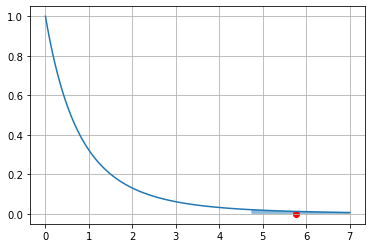

In [55]:
F = (r2 / k1) / ((1 - r2) / k2)
print('F = {:.8f}'.format(F))
plot_fisher(k1, k2, t, f_stat=F)

In [56]:
print('Ответ: {}'.format(int(F > t)))

Ответ: 1


### Задача 3

Для проведения A/B-тестирования сайта интернет-магазина были получены следующие данные: страница A была посещена 2509 раз, из них 77 закончились совершением покупки, страница B была посещена 1465 раз, 60 из них закончились совершением покупки. Является ли значимым отличие конверсии на страницах A и B? В качестве ответа запишите 1, если является, и 0 иначе.

_Подсказка_. Реализуйте двухвыборочный t-тест. В качестве выборок здесь можно взять наборы меток совершения покупки (0 или 1) каждым посетителем.

Ответ: 0

In [88]:
A_views = 2509
A_buy = 77

B_views = 1465
B_buy = 60

a = np.append(np.zeros((A_views - A_buy, 1)), np.ones((A_buy, 1)))
np.random.shuffle(a)
b = np.append(np.zeros((B_views - B_buy, 1)), np.ones((B_buy, 1)))
np.random.shuffle(b)

t_test_result = stats.ttest_ind(a, b, equal_var=False)

print('t-statistic = {}\tp-value = {}'.format(*t_test_result))

print("гипотеза верна" if t_test_result.pvalue > alpha else 'гипотеза не верна')

t-statistic = -1.6504551408398205	p-value = 0.09896479217925895
гипотеза верна
